In [336]:
# https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/Simple_GP_Regression.html
# https://github.com/cornellius-gp/gpytorch/blob/master/examples/01_Exact_GPs/Simple_GP_Regression.ipynb

In [337]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

In [338]:
# use this to test on hifi data
import numpy as np
# train_x, train_y = np.load("test-lofi.npy")
train_x, train_y = np.load("test-hifi.npy")
# train_x, train_y = np.load("test-bridge.npy")
train_x = torch.as_tensor(train_x, dtype=torch.float32)
train_y = torch.as_tensor(train_y, dtype=torch.float32)

In [339]:
train_x.dtype

torch.float32

In [340]:
train_y.dtype

torch.float32

In [341]:
# # Training data is 100 points in [0,1] inclusive regularly spaced
# train_x = torch.linspace(0, 1, 100)
# # True function is sin(2*pi*x) with Gaussian noise
# train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

# # no noise
# # train_y = torch.sin(train_x * (2 * math.pi))

In [342]:
train_x.dtype

torch.float32

In [343]:
train_y.dtype

torch.float32

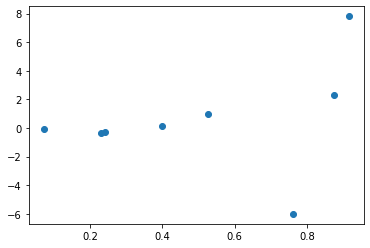

In [344]:
plt.figure()
plt.plot(train_x, train_y, 'o')

In [345]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [346]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [347]:
# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

In [348]:

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


In [349]:
training_iter = 200
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    if i % 100 == 0:
        print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
            i + 1, training_iter, loss.item(),
            model.covar_module.base_kernel.lengthscale.item(),
            model.likelihood.noise.item()
        ))
    optimizer.step()

Iter 1/200 - Loss: 9.604   lengthscale: 0.693   noise: 0.693
Iter 101/200 - Loss: 2.649   lengthscale: 0.033   noise: 2.560


In [350]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()


GaussianLikelihood(
  (noise_covar): HomoskedasticNoise(
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
)

In [351]:
# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 501)
    observed_pred = likelihood(model(test_x))

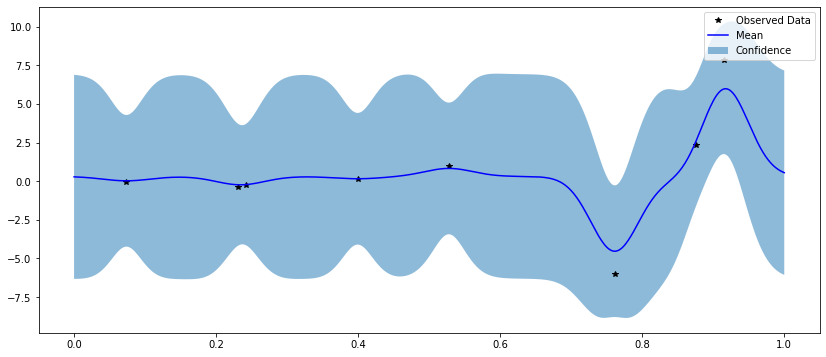

In [352]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(14, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
#     ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])